# Using PyDAP for simple remote data access using DAP4

This notebook contains a simple example of how to use the NetCDF Python interface and DAP4 to pull data from remote DAP4 servers into your Python program's memory space so that the data may be analyized and displayed.

We show how to use simple HTTP requests to look at a dataset's metadata and how to use the NetCDF Python package to read data into numpy arrays and plot (or do other things) with those data. NetCDF Python provides lazy evaluation, so data are read only when needed.

This tutorial utilizes the NASA Global High Resolution Sea Surface Temperature from the GOES-16 satellite. You may wish to review the summary on our Tutorial Datasets page before continuing.

Copyright (C) 2023 OPeNDAP, Inc. This Jupyter Notebook is made available under the Creative Commons Attribution license 4.0.


In [1]:
import netCDF4

In [6]:
USE_NASA_CLOUD_BASED_DATA = True

# NOTE: When I used a URL using opendap.earthdata.nasa.gov and the 'https' protocol, I got an error 
# that said the library could not build a DAP2 object from a DAP4 response. This is NOT using PyDAP
# but instead using the Python wrappers calling the NetCDF 4.8.1 C library. 
#
# This is the error message (with some reformatting):  
# Syntax error, unexpected $end, expecting ';'
# context: Error {  code = 400; message = "ERROR: Unable to convert a DAP4 DMR for this dataset to a 
# DAP2 DDS object. This dataset contains variables and/or attributes whose data types are not compatible 
# with the DAP2 data model.There are 46 incompatible variables and/or attributes referenced in your request ...
#
# This is repeatable without needing to restart jupyter. Note that the underlying C library is 4.8.1.
# This may goaway if/when the python package (I'm using conda for the binary) moves up to 4.9.x. jhrg 3/24/23

if(USE_NASA_CLOUD_BASED_DATA):
    dataset_url = "dap4://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220812010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220812_010000-v02.0-fv01.0"
else:
    dataset_url = "dap4://test.opendap.org/opendap/tutorials/20220812010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220812_010000-v02.0-fv01.0.nc"

print ("dataset_url: ", dataset_url)

dataset_url:  dap4://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220812010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220812_010000-v02.0-fv01.0


In [7]:
f = netCDF4.Dataset(dataset_url, 'r')
print(f"NetCDF4 dataset: {f}") 

NetCDF4 dataset: <class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format DAP4):
    Conventions: CF-1.4
    title: Sea Surface Temperature
    summary: The L3C product derived from GOES16/ABI brightness temperatures.
    references: Geostationary Sea Surface Temperature Product User Manual, http://www.osi-saf.org
    institution: OSISAF
    comment: 
    license: All intellectual property rights of the Ocean &amp; Sea Ice SAF products belong to EUMETSAT. The use of these products is granted to every user, free of charge. If users wish to use these products, EUMETSAT&apos;s copyright credit must be shown by displaying the words &apos;Copyright EUMETSAT&apos; under each of the products shown. EUMETSAT offers no warranty and accepts no liability in respect of the Ocean &amp; Sea Ice SAF products. EUMETSAT neither commits to nor guarantees the continuity, availability, or quality or suitability for any purpose of, the Ocean &amp; Sea Ice SAF products.
    id: GOES16-

In [24]:
lat = f.variables['lat']  # temperature variable
print(f"Latitude: {lat}")

Latitude: <class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    long_name: latitude
    standard_name: latitude
    axis: Y
    units: degrees_north
    valid_min: -90.000046
    valid_max: 90.000015
    comment: geographical coordinates, WGS84 projection
unlimited dimensions: 
current shape = (2400,)
filling on, default _FillValue of 9.969209968386869e+36 used


In [25]:
for dname, d in f.dimensions.items():
    print(d)


<class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 1
<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 2400
<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 2400


In [26]:
lat.dimensions

('lat',)

In [27]:
f.variables['lat'].shape

(2400,)

In [28]:
f.variables['sea_surface_temperature'].shape

(1, 2400, 2400)

In [29]:
latitude = f.variables['lat'][:]

checksumhack=0


In [30]:
latitude

masked_array(data=[-59.975, -59.925, -59.875, ...,  59.875,  59.925,
                    59.975],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [31]:
longitude = f.variables['lon'][:]

In [32]:
longitude

masked_array(data=[-134.975, -134.925, -134.875, ...,  -15.125,  -15.075,
                    -15.025],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [35]:
sst = f.variables['sea_surface_temperature'][:]
print(f"Sea Surface Temperature shape: {sst.shape}")
print(f"Sea Surface Temperature: {sst}")

Sea Surface Temperature shape: (1, 2400, 2400)
Sea Surface Temperature: [[[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- -- -- ... -- -- --]
  [-- -- -- ... 288.28 288.28 288.28]
  [-- -- -- ... 286.59999999999997 286.59999999999997 --]]]


In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

import numpy as np

# NB conda install -c conda-forge matplotlib numpy basemap; but installed each separately. jhrg 3/22/23

In [37]:
#np.squeeze(sst)
sst = np.squeeze(sst)
print(f"Sea Surface Temperature shape: {sst.shape}")

Sea Surface Temperature shape: (2400, 2400)


X (2400, 2400)
Y (2400, 2400)
sst (2400, 2400)


Text(0.5, 1.0, 'Sea Surface Temperature')

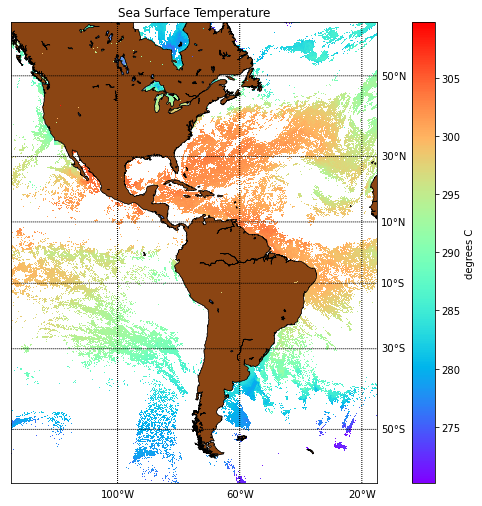

In [38]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# BaseMap
# The resolution can be l (low), i (intermediate), h (high), f (full)
# But you have to install/configure everything but low
#
# These bounds were chosen based on the bounds of the data. The bounds
# are documented on the TuorialsDatasets page: 
# https://opendap.github.io/documentation/tutorials/TutorialDatasets.html
#
m = Basemap(
    llcrnrlon=-135.,
    llcrnrlat=-60.,
    urcrnrlon=-15.,
    urcrnrlat=60.,
    resolution='l',
    projection='merc')

m.fillcontinents(color='saddlebrown',lake_color='cornflowerblue')

# draw lat and lon line (parallels and meridians).
# and set the axis labels (labels = [left,right,top,bottom])
parallels = np.arange(-70., 80., 20.)
m.drawparallels(parallels, labels=[False,True,False,False])
meridians = np.arange(-180., 180., 40.)
m.drawmeridians(meridians, labels=[False,False,False,True])

# Use meshgrid(lon, lat) to build matrices for the lon, lat values
# and then convert them to map projection coordinates for the Basemap
# object 'm.'

X, Y = m(*np.meshgrid(longitude, latitude))

print("X", X.shape)
print("Y", Y.shape)
print("sst", sst.shape)

# Plot using the rainbox color map
colors_ = m.pcolormesh(X, Y, sst, cmap=plt.get_cmap('rainbow'))

m.drawcoastlines(linewidth=0.5)

cb = plt.colorbar(colors_)
cb.set_label("degrees C")
m.drawcoastlines(linewidth=0.5)

ax.set_title('Sea Surface Temperature')